##1


In [1]:
# Install necessary libraries
!pip install torchinfo torchmetrics

# Import required libraries
import os
import zipfile
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from torchinfo import summary
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from tqdm.notebook import tqdm

# Set device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

##2

In [2]:
import io
from torch.utils.data import Dataset, DataLoader, random_split

class PairedImageZipDataset(Dataset):
    """
    Custom PyTorch Dataset for loading paired images from a zip file.
    (Corrected to handle potential format mismatches within the zip)

    Args:
        zip_path (str): Path to the zip file.
        transform (callable, optional): A function/transform to apply to the images.
    """
    def __init__(self, zip_path="archive.zip", transform=None):
        self.zip_path = zip_path
        self.transform = transform

        with zipfile.ZipFile(self.zip_path, 'r') as z:
            # This logic correctly finds both .jpg and .png files.
            input_files = [f for f in z.namelist() if f.startswith('Rain100L/input/') and (f.endswith('.png') or f.endswith('.jpg'))]

            self.input_paths = sorted(input_files)
            self.target_paths = [p.replace('input', 'target') for p in self.input_paths]

        self.zip_file = zipfile.ZipFile(self.zip_path, 'r')

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        # --- FIX APPLIED HERE ---
        # Read file content into an in-memory buffer (io.BytesIO) before opening.
        # This makes the loading more robust to format/extension mismatches.
        try:
            with self.zip_file.open(self.input_paths[idx]) as f:
                buffer = io.BytesIO(f.read())
                input_image = Image.open(buffer).convert("RGB")

            with self.zip_file.open(self.target_paths[idx]) as f:
                buffer = io.BytesIO(f.read())
                target_image = Image.open(buffer).convert("RGB")
        except Exception as e:
            print(f"Error loading image index {idx}: {self.input_paths[idx]}. Error: {e}")
            # Return None or a placeholder if an image is corrupt
            return None, None

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

# This custom collate function will filter out any samples that failed to load
def collate_fn(batch):
    # Filter out None entries
    batch = [b for b in batch if b[0] is not None]
    if not batch:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)


# Define image transformations
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create the dataset
# Make sure 'archive.zip' is in your Colab root directory
try:
    full_dataset = PairedImageZipDataset(zip_path="archive.zip", transform=image_transform)

    # Define split sizes for 80% train, 10% validation, 10% test
    dataset_size = len(full_dataset)
    train_size = int(0.8 * dataset_size)
    val_size = int(0.1 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Create DataLoaders with the custom collate_fn
    BATCH_SIZE = 4
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)

    print(f"Dataset loaded and split successfully.")
    print(f"Total images: {dataset_size}")
    print(f"Training images: {len(train_dataset)}")
    print(f"Validation images: {len(val_dataset)}")
    print(f"Testing images: {len(test_dataset)}")

except FileNotFoundError:
    print("Error: 'archive.zip' not found. Please upload your dataset.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure your zip file has the structure: 'Rain100L/input/' and 'Rain100L/target/'.")


Dataset loaded and split successfully.
Total images: 100
Training images: 80
Validation images: 10
Testing images: 10


##3

In [3]:
# --- Attention Modules ---

class SELayer(nn.Module):
    """ Squeeze-and-Excitation block """
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class CBAM(nn.Module):
    """ Convolutional Block Attention Module (Our Modification) """
    def __init__(self, channel, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        # Spatial Attention
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel attention
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        channel_att = self.sigmoid(avg_out + max_out)
        x = x * channel_att

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        x = x * spatial_att
        return x

# --- Core Recurrent Block ---

class RecurrentBlock(nn.Module):
    """ The core recurrent block of the RESCAN model. """
    def __init__(self, num_filter, kernel_size=3, stride=1, padding=1):
        super(RecurrentBlock, self).__init__()

        self.conv1 = nn.Conv2d(num_filter*2, num_filter, kernel_size, stride, padding, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filter, num_filter, kernel_size, stride, padding, bias=True)

        self.se = SELayer(num_filter)
        self.cbam = CBAM(num_filter) # Our added attention module

    def forward(self, x, h):
        # Concatenate input features (x) and hidden state (h)
        x_h = torch.cat((x, h), 1)

        # First convolution
        x1 = self.relu1(self.conv1(x_h))

        # Second convolution
        h_next = self.conv2(x1)

        # Apply attention mechanisms
        h_next = self.se(h_next)
        h_next = self.cbam(h_next) # Applying our modification

        return h_next

# --- Full RESCAN Model ---

class RESCAN(nn.Module):
    """ The main modified RESCAN model. """
    def __init__(self, in_channels=3, out_channels=3, num_filter=32, num_stages=4):
        super(RESCAN, self).__init__()

        self.num_stages = num_stages

        # Initial feature extraction layer
        self.conv_in = nn.Conv2d(in_channels, num_filter, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu_in = nn.ReLU(inplace=True)

        # The recurrent block that will be unrolled
        self.recurrent_block = RecurrentBlock(num_filter)

        # Final reconstruction layer
        self.conv_out = nn.Conv2d(num_filter, out_channels, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):
        # Initial feature extraction
        x_in = self.relu_in(self.conv_in(x))

        # Initialize hidden state with zeros
        h = torch.zeros_like(x_in)

        # Unroll the recurrent block over stages
        for _ in range(self.num_stages):
            h = self.recurrent_block(x_in, h)

        # Reconstruct the image from the final hidden state
        out = self.conv_out(h)

        # Add the residual (the clean image is the rainy image minus the rain layer)
        final_out = x + out

        return final_out


In [5]:
# Initialize the model
# You can adjust num_filter and num_stages to control model capacity
model = RESCAN(num_filter=64, num_stages=5).to(device)

# --- Print Model Summary ---
# The input size for the summary should match our data (Batch, Channels, Height, Width)
# We use a dummy size as the model is fully convolutional and can handle variable sizes.
input_size = (BATCH_SIZE, 3, 256, 256)

print("--- Modified RESCAN Model Summary ---")
summary(model, input_size=input_size)


--- Modified RESCAN Model Summary ---


Layer (type:depth-idx)                   Output Shape              Param #
RESCAN                                   [4, 3, 256, 256]          --
├─Conv2d: 1-1                            [4, 64, 256, 256]         1,792
├─ReLU: 1-2                              [4, 64, 256, 256]         --
├─RecurrentBlock: 1-3                    [4, 64, 256, 256]         --
│    └─Conv2d: 2-1                       [4, 64, 256, 256]         73,792
│    └─ReLU: 2-2                         [4, 64, 256, 256]         --
│    └─Conv2d: 2-3                       [4, 64, 256, 256]         36,928
│    └─SELayer: 2-4                      [4, 64, 256, 256]         --
│    │    └─AdaptiveAvgPool2d: 3-1       [4, 64, 1, 1]             --
│    │    └─Sequential: 3-2              [4, 64]                   512
│    └─CBAM: 2-5                         [4, 64, 256, 256]         --
│    │    └─AdaptiveAvgPool2d: 3-3       [4, 64, 1, 1]             --
│    │    └─Sequential: 3-4              [4, 64, 1, 1]             512
│ 

##4

In [6]:
# --- Hyperparameters ---
EPOCHS = 100
LR = 0.0001

# --- Loss Function and Optimizer ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- Training History ---
train_losses = []
val_losses = [] # Changed from eval_losses to val_losses for clarity

# --- Training ---
print("Starting Training...")

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0

    train_progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")

    for rainy_img, clean_img in train_progress_bar:
        rainy_img = rainy_img.to(device)
        clean_img = clean_img.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        derained_img = model(rainy_img)
        loss = criterion(derained_img, clean_img)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_progress_bar.set_postfix(Loss=loss.item())

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    val_progress_bar = tqdm(val_loader, total=len(val_loader), desc=f"Epoch {epoch+1}/{EPOCHS} [Validate]")

    with torch.no_grad():
        for rainy_img, clean_img in val_progress_bar:
            rainy_img = rainy_img.to(device)
            clean_img = clean_img.to(device)

            derained_img = model(rainy_img)
            loss = criterion(derained_img, clean_img)

            running_val_loss += loss.item()
            val_progress_bar.set_postfix(Loss=loss.item())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"\nEnd of Epoch {epoch+1}/{EPOCHS} -> Train Loss: {avg_train_loss:.6f} | Validation Loss: {avg_val_loss:.6f}")

print("Finished Training.")


Starting Training...


Epoch 1/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 23: Rain100L/input/3.png. Error: File name in directory 'Rain100L/target/3.png' and header b'Rain100L/target/79.png' differ.Error loading image index 77: Rain100L/input/79.png. Error: Bad magic number for file header

Error loading image index 45: Rain100L/input/5.png. Error: Bad magic number for file headerError loading image index 58: Rain100L/input/61.png. Error: Bad CRC-32 for file 'Rain100L/target/61.png'



Epoch 1/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 1/100 -> Train Loss: 0.003265 | Validation Loss: 0.002504


Epoch 2/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 94: Rain100L/input/94.png. Error: Error -3 while decompressing data: invalid distance too far back
Error loading image index 82: Rain100L/input/83.png. Error: Error -3 while decompressing data: invalid distance too far back


Epoch 2/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 93: Rain100L/input/93.png. Error: Bad magic number for file headerError loading image index 30: Rain100L/input/36.png. Error: File name in directory 'Rain100L/target/36.png' and header b'Rain100L/target/93.png' differ.


End of Epoch 2/100 -> Train Loss: 0.002710 | Validation Loss: 0.002769


Epoch 3/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 3/100 -> Train Loss: 0.002612 | Validation Loss: 0.002411


Epoch 4/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 35: Rain100L/input/40.png. Error: Bad magic number for file headerError loading image index 32: Rain100L/input/38.png. Error: Bad CRC-32 for file 'Rain100L/input/38.png'



Epoch 4/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 4/100 -> Train Loss: 0.002540 | Validation Loss: 0.002388


Epoch 5/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 56: Rain100L/input/6.png. Error: Bad magic number for file header
Error loading image index 34: Rain100L/input/4.png. Error: Error -3 while decompressing data: too many length or distance symbols
Error loading image index 60: Rain100L/input/63.png. Error: Overlapped entries: 'Rain100L/input/63.png' (possible zip bomb)
Error loading image index 84: Rain100L/input/85.png. Error: Error -3 while decompressing data: invalid distance too far backError loading image index 10: Rain100L/input/18.png. Error: Error -3 while decompressing data: invalid block type



Epoch 5/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 5/100 -> Train Loss: 0.002448 | Validation Loss: 0.002232


Epoch 6/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 6/100 -> Train Loss: 0.002286 | Validation Loss: 0.002067


Epoch 7/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 84: Rain100L/input/85.png. Error: Overlapped entries: 'Rain100L/input/85.png' (possible zip bomb)
Error loading image index 8: Rain100L/input/16.png. Error: Error -3 while decompressing data: invalid code lengths setError loading image index 3: Rain100L/input/11.png. Error: Bad magic number for file header



Epoch 7/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 7/100 -> Train Loss: 0.002035 | Validation Loss: 0.001920


Epoch 8/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 79: Rain100L/input/80.png. Error: File name in directory 'Rain100L/input/80.png' and header b'Rain100L/input/4.png' differ.
Error loading image index 34: Rain100L/input/4.png. Error: Bad magic number for file header


Epoch 8/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 8/100 -> Train Loss: 0.001850 | Validation Loss: 0.001890


Epoch 9/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 29: Rain100L/input/35.png. Error: Error -3 while decompressing data: invalid distance too far back


Epoch 9/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 9/100 -> Train Loss: 0.001752 | Validation Loss: 0.001836


Epoch 10/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 10/100 -> Train Loss: 0.001746 | Validation Loss: 0.001816


Epoch 11/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 22: Rain100L/input/29.png. Error: Error -3 while decompressing data: invalid code lengths set

End of Epoch 11/100 -> Train Loss: 0.001654 | Validation Loss: 0.001813


Epoch 12/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 84: Rain100L/input/85.png. Error: Bad CRC-32 for file 'Rain100L/input/85.png'


Epoch 12/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 12/100 -> Train Loss: 0.001582 | Validation Loss: 0.001682


Epoch 13/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 6: Rain100L/input/14.png. Error: Bad magic number for file headerError loading image index 17: Rain100L/input/24.png. Error: Bad CRC-32 for file 'Rain100L/target/24.png'



Epoch 13/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 13/100 -> Train Loss: 0.001479 | Validation Loss: 0.001687


Epoch 14/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 14/100 -> Train Loss: 0.001486 | Validation Loss: 0.001660


Epoch 15/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 12: Rain100L/input/2.png. Error: Overlapped entries: 'Rain100L/target/2.png' (possible zip bomb)


Epoch 15/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 15/100 -> Train Loss: 0.001426 | Validation Loss: 0.001537


Epoch 16/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 16/100 -> Train Loss: 0.001468 | Validation Loss: 0.001511


Epoch 17/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 17/100 -> Train Loss: 0.001372 | Validation Loss: 0.001494


Epoch 18/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 18/100 -> Train Loss: 0.001339 | Validation Loss: 0.001727


Epoch 19/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 19/100 -> Train Loss: 0.001315 | Validation Loss: 0.001746


Epoch 20/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 20/100 -> Train Loss: 0.001331 | Validation Loss: 0.001525


Epoch 21/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 18: Rain100L/input/25.png. Error: Error -3 while decompressing data: invalid distance too far back


Epoch 21/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 21/100 -> Train Loss: 0.001258 | Validation Loss: 0.001660


Epoch 22/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 55: Rain100L/input/59.png. Error: Bad magic number for file headerError loading image index 80: Rain100L/input/81.png. Error: Bad CRC-32 for file 'Rain100L/input/81.png'


End of Epoch 22/100 -> Train Loss: 0.001271 | Validation Loss: 0.001689


Epoch 23/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 35: Rain100L/input/40.png. Error: Overlapped entries: 'Rain100L/target/40.png' (possible zip bomb)Error loading image index 47: Rain100L/input/51.png. Error: Bad magic number for file header



Epoch 23/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 23/100 -> Train Loss: 0.001230 | Validation Loss: 0.001456


Epoch 24/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 24/100 -> Train Loss: 0.001214 | Validation Loss: 0.001552


Epoch 25/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 59: Rain100L/input/62.png. Error: Error -3 while decompressing data: invalid stored block lengthsError loading image index 66: Rain100L/input/69.png. Error: Error -3 while decompressing data: invalid block type



Epoch 25/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 25/100 -> Train Loss: 0.001224 | Validation Loss: 0.001643


Epoch 26/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 8: Rain100L/input/16.png. Error: Overlapped entries: 'Rain100L/target/16.png' (possible zip bomb)


Epoch 26/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 26/100 -> Train Loss: 0.001187 | Validation Loss: 0.001529


Epoch 27/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 32: Rain100L/input/38.png. Error: File name in directory 'Rain100L/input/38.png' and header b'Rain100L/target/18.png' differ.Error loading image index 10: Rain100L/input/18.png. Error: Bad magic number for file header

Error loading image index 57: Rain100L/input/60.png. Error: Bad magic number for file headerError loading image index 92: Rain100L/input/92.png. Error: File name in directory 'Rain100L/target/92.png' and header b'Rain100L/input/60.png' differ.



Epoch 27/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 27/100 -> Train Loss: 0.001220 | Validation Loss: 0.001488


Epoch 28/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 93: Rain100L/input/93.png. Error: Bad magic number for file headerError loading image index 30: Rain100L/input/36.png. Error: Bad CRC-32 for file 'Rain100L/target/36.png'


End of Epoch 28/100 -> Train Loss: 0.001213 | Validation Loss: 0.001393


Epoch 29/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 29/100 -> Train Loss: 0.001156 | Validation Loss: 0.001416


Epoch 30/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 30/100 -> Train Loss: 0.001159 | Validation Loss: 0.001382


Epoch 31/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 31/100 -> Train Loss: 0.001136 | Validation Loss: 0.001319


Epoch 32/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 32/100 -> Train Loss: 0.001147 | Validation Loss: 0.001355


Epoch 33/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 33/100 -> Train Loss: 0.001108 | Validation Loss: 0.001459


Epoch 34/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 71: Rain100L/input/73.png. Error: Overlapped entries: 'Rain100L/target/73.png' (possible zip bomb)Error loading image index 12: Rain100L/input/2.png. Error: Error -3 while decompressing data: invalid code lengths set



Epoch 34/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 34/100 -> Train Loss: 0.001122 | Validation Loss: 0.001350


Epoch 35/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 35/100 -> Train Loss: 0.001110 | Validation Loss: 0.001304


Epoch 36/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 36/100 -> Train Loss: 0.001121 | Validation Loss: 0.001335


Epoch 37/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 37/100 -> Train Loss: 0.001091 | Validation Loss: 0.001447


Epoch 38/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 38/100 -> Train Loss: 0.001076 | Validation Loss: 0.001326


Epoch 39/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 39/100 -> Train Loss: 0.001093 | Validation Loss: 0.001511


Epoch 40/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 40/100 -> Train Loss: 0.001086 | Validation Loss: 0.001603


Epoch 41/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 41/100 -> Train Loss: 0.001094 | Validation Loss: 0.001465


Epoch 42/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 47: Rain100L/input/51.png. Error: Bad CRC-32 for file 'Rain100L/target/51.png'Error loading image index 63: Rain100L/input/66.png. Error: Bad magic number for file header



Epoch 42/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 42/100 -> Train Loss: 0.001073 | Validation Loss: 0.001302


Epoch 43/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 43/100 -> Train Loss: 0.001049 | Validation Loss: 0.001487


Epoch 44/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 44/100 -> Train Loss: 0.001056 | Validation Loss: 0.001299


Epoch 45/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 45/100 -> Train Loss: 0.001075 | Validation Loss: 0.001337


Epoch 46/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 49: Rain100L/input/53.png. Error: Error -3 while decompressing data: invalid distance too far back
Error loading image index 34: Rain100L/input/4.png. Error: Error -3 while decompressing data: invalid block type


Epoch 46/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 46/100 -> Train Loss: 0.001050 | Validation Loss: 0.001346


Epoch 47/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 33: Rain100L/input/39.png. Error: Error -3 while decompressing data: invalid block type
Error loading image index 81: Rain100L/input/82.png. Error: Error -3 while decompressing data: invalid code lengths set


Epoch 47/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 47/100 -> Train Loss: 0.001092 | Validation Loss: 0.001316


Epoch 48/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 85: Rain100L/input/86.png. Error: Error -3 while decompressing data: invalid code lengths set


Epoch 48/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 48/100 -> Train Loss: 0.001159 | Validation Loss: 0.001318


Epoch 49/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 49/100 -> Train Loss: 0.001069 | Validation Loss: 0.001463


Epoch 50/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 15: Rain100L/input/22.png. Error: Error -3 while decompressing data: invalid code lengths set
Error loading image index 82: Rain100L/input/83.png. Error: Overlapped entries: 'Rain100L/input/83.png' (possible zip bomb)


Epoch 50/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 50/100 -> Train Loss: 0.001056 | Validation Loss: 0.001496


Epoch 51/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 51/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 51/100 -> Train Loss: 0.001069 | Validation Loss: 0.001294


Epoch 52/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 92: Rain100L/input/92.png. Error: Bad magic number for file headerError loading image index 84: Rain100L/input/85.png. Error: Bad CRC-32 for file 'Rain100L/input/85.png'

Error loading image index 44: Rain100L/input/49.png. Error: Error -3 while decompressing data: invalid stored block lengths
Error loading image index 96: Rain100L/input/96.png. Error: Overlapped entries: 'Rain100L/input/96.png' (possible zip bomb)


Epoch 52/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 52/100 -> Train Loss: 0.001037 | Validation Loss: 0.001416


Epoch 53/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 61: Rain100L/input/64.png. Error: Overlapped entries: 'Rain100L/input/64.png' (possible zip bomb)

End of Epoch 53/100 -> Train Loss: 0.001016 | Validation Loss: 0.001488


Epoch 54/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 54/100 -> Train Loss: 0.001022 | Validation Loss: 0.001504


Epoch 55/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 9: Rain100L/input/17.png. Error: Bad CRC-32 for file 'Rain100L/input/17.png'


Epoch 55/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 62: Rain100L/input/65.png. Error: Bad magic number for file headerError loading image index 61: Rain100L/input/64.png. Error: Overlapped entries: 'Rain100L/target/64.png' (possible zip bomb)


End of Epoch 55/100 -> Train Loss: 0.001031 | Validation Loss: 0.001253


Epoch 56/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 56/100 -> Train Loss: 0.001020 | Validation Loss: 0.001280


Epoch 57/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 94: Rain100L/input/94.png. Error: Error -3 while decompressing data: invalid block type


Epoch 57/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 57/100 -> Train Loss: 0.001026 | Validation Loss: 0.001278


Epoch 58/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 23: Rain100L/input/3.png. Error: Overlapped entries: 'Rain100L/input/3.png' (possible zip bomb)


Epoch 58/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 58/100 -> Train Loss: 0.000992 | Validation Loss: 0.001408


Epoch 59/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 59/100 -> Train Loss: 0.000996 | Validation Loss: 0.001309


Epoch 60/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 62: Rain100L/input/65.png. Error: File name in directory 'Rain100L/target/65.png' and header b'Rain100L/input/64.png' differ.Error loading image index 61: Rain100L/input/64.png. Error: Bad magic number for file header


End of Epoch 60/100 -> Train Loss: 0.001002 | Validation Loss: 0.001224


Epoch 61/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 61/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 61/100 -> Train Loss: 0.001033 | Validation Loss: 0.001333


Epoch 62/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 62/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 62/100 -> Train Loss: 0.000994 | Validation Loss: 0.001530


Epoch 63/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 65: Rain100L/input/68.png. Error: Bad CRC-32 for file 'Rain100L/target/68.png'Error loading image index 74: Rain100L/input/76.png. Error: Error -3 while decompressing data: invalid block type



Epoch 63/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 63/100 -> Train Loss: 0.000983 | Validation Loss: 0.001251


Epoch 64/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 64/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 64/100 -> Train Loss: 0.001024 | Validation Loss: 0.001243


Epoch 65/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 65/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 65/100 -> Train Loss: 0.001016 | Validation Loss: 0.001301


Epoch 66/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 66/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 66/100 -> Train Loss: 0.000980 | Validation Loss: 0.001244


Epoch 67/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 67/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 22: Rain100L/input/29.png. Error: Error -3 while decompressing data: invalid distance codeError loading image index 93: Rain100L/input/93.png. Error: Error -3 while decompressing data: invalid stored block lengths


End of Epoch 67/100 -> Train Loss: 0.000981 | Validation Loss: 0.001271


Epoch 68/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 68/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 68/100 -> Train Loss: 0.000974 | Validation Loss: 0.001274


Epoch 69/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 69/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 69/100 -> Train Loss: 0.000989 | Validation Loss: 0.001225


Epoch 70/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 70/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 70/100 -> Train Loss: 0.000978 | Validation Loss: 0.001402


Epoch 71/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 89: Rain100L/input/9.png. Error: Error -3 while decompressing data: invalid distance too far back


Epoch 71/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 71/100 -> Train Loss: 0.000964 | Validation Loss: 0.001251


Epoch 72/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 72/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 72/100 -> Train Loss: 0.000955 | Validation Loss: 0.001312


Epoch 73/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 9: Rain100L/input/17.png. Error: Bad magic number for file headerError loading image index 44: Rain100L/input/49.png. Error: Bad CRC-32 for file 'Rain100L/input/49.png'



Epoch 73/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 73/100 -> Train Loss: 0.000973 | Validation Loss: 0.001354


Epoch 74/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 89: Rain100L/input/9.png. Error: Overlapped entries: 'Rain100L/input/9.png' (possible zip bomb)Error loading image index 65: Rain100L/input/68.png. Error: Bad magic number for file header



Epoch 74/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 74/100 -> Train Loss: 0.000943 | Validation Loss: 0.001276


Epoch 75/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 40: Rain100L/input/45.png. Error: Error -3 while decompressing data: invalid stored block lengthsError loading image index 23: Rain100L/input/3.png. Error: Bad CRC-32 for file 'Rain100L/input/3.png'



Epoch 75/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 75/100 -> Train Loss: 0.000937 | Validation Loss: 0.001280


Epoch 76/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 81: Rain100L/input/82.png. Error: Error -3 while decompressing data: invalid code lengths setError loading image index 45: Rain100L/input/5.png. Error: Error -3 while decompressing data: invalid distance too far back



Epoch 76/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 76/100 -> Train Loss: 0.000950 | Validation Loss: 0.001337


Epoch 77/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 77/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 77/100 -> Train Loss: 0.000950 | Validation Loss: 0.001479


Epoch 78/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 78/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 78/100 -> Train Loss: 0.000954 | Validation Loss: 0.001340


Epoch 79/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 58: Rain100L/input/61.png. Error: Error -3 while decompressing data: invalid stored block lengthsError loading image index 24: Rain100L/input/30.png. Error: Bad magic number for file header



Epoch 79/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 79/100 -> Train Loss: 0.000936 | Validation Loss: 0.001261


Epoch 80/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 80/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 80/100 -> Train Loss: 0.000934 | Validation Loss: 0.001310


Epoch 81/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 81/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 81/100 -> Train Loss: 0.000930 | Validation Loss: 0.001316


Epoch 82/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 82/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 82/100 -> Train Loss: 0.000918 | Validation Loss: 0.001322


Epoch 83/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 83/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 80: Rain100L/input/81.png. Error: Bad magic number for file header
Error loading image index 55: Rain100L/input/59.png. Error: Bad CRC-32 for file 'Rain100L/target/59.png'

End of Epoch 83/100 -> Train Loss: 0.000922 | Validation Loss: 0.001404


Epoch 84/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 84/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 84/100 -> Train Loss: 0.000922 | Validation Loss: 0.001261


Epoch 85/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 85/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 62: Rain100L/input/65.png. Error: Error -3 while decompressing data: invalid code lengths set
Error loading image index 61: Rain100L/input/64.png. Error: Overlapped entries: 'Rain100L/input/64.png' (possible zip bomb)

End of Epoch 85/100 -> Train Loss: 0.000921 | Validation Loss: 0.001141


Epoch 86/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 86/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 22: Rain100L/input/29.png. Error: Error -3 while decompressing data: invalid code lengths setError loading image index 21: Rain100L/input/28.png. Error: Error -3 while decompressing data: invalid stored block lengths


End of Epoch 86/100 -> Train Loss: 0.000907 | Validation Loss: 0.001238


Epoch 87/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 87/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 87/100 -> Train Loss: 0.000916 | Validation Loss: 0.001227


Epoch 88/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Error loading image index 33: Rain100L/input/39.png. Error: Overlapped entries: 'Rain100L/input/39.png' (possible zip bomb)


Epoch 88/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 88/100 -> Train Loss: 0.000902 | Validation Loss: 0.001256


Epoch 89/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 89/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 93: Rain100L/input/93.png. Error: Error -3 while decompressing data: invalid distance code
Error loading image index 30: Rain100L/input/36.png. Error: Error -3 while decompressing data: invalid distance too far back

End of Epoch 89/100 -> Train Loss: 0.000926 | Validation Loss: 0.001288


Epoch 90/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 90/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 90/100 -> Train Loss: 0.000938 | Validation Loss: 0.001394


Epoch 91/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 91/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 62: Rain100L/input/65.png. Error: Error -3 while decompressing data: invalid block typeError loading image index 61: Rain100L/input/64.png. Error: Error -3 while decompressing data: invalid literal/length code


End of Epoch 91/100 -> Train Loss: 0.000894 | Validation Loss: 0.001272


Epoch 92/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 92/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 92/100 -> Train Loss: 0.000897 | Validation Loss: 0.001222


Epoch 93/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 93/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 93/100 -> Train Loss: 0.000880 | Validation Loss: 0.001241


Epoch 94/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 94/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 94/100 -> Train Loss: 0.000876 | Validation Loss: 0.001268


Epoch 95/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 95/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 95/100 -> Train Loss: 0.000890 | Validation Loss: 0.001228


Epoch 96/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 96/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 96/100 -> Train Loss: 0.000879 | Validation Loss: 0.001239


Epoch 97/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 97/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 97/100 -> Train Loss: 0.000890 | Validation Loss: 0.001232


Epoch 98/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 98/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 98/100 -> Train Loss: 0.000891 | Validation Loss: 0.001366


Epoch 99/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 99/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]


End of Epoch 99/100 -> Train Loss: 0.000870 | Validation Loss: 0.001238


Epoch 100/100 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 100/100 [Validate]:   0%|          | 0/3 [00:00<?, ?it/s]

Error loading image index 21: Rain100L/input/28.png. Error: Bad magic number for file header
Error loading image index 22: Rain100L/input/29.png. Error: Bad CRC-32 for file 'Rain100L/target/29.png'

End of Epoch 100/100 -> Train Loss: 0.000866 | Validation Loss: 0.001265
Finished Training.


##5

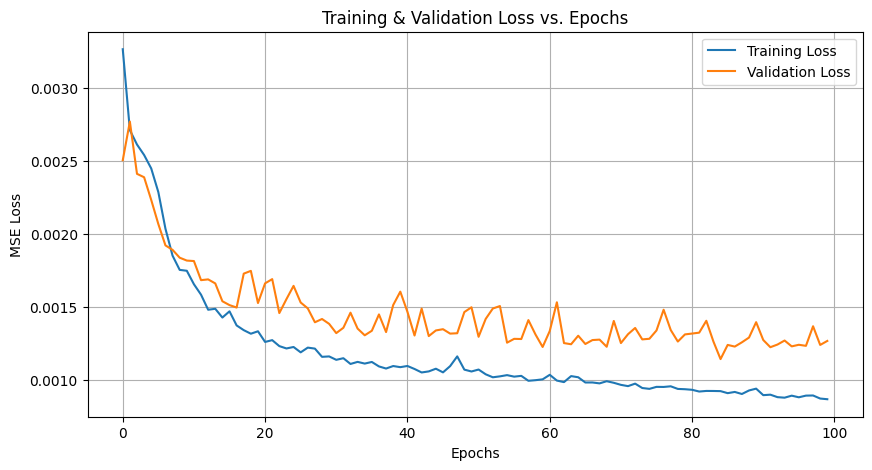

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Calculating Final Metrics on Test Set:   0%|          | 0/3 [00:00<?, ?it/s]


--- Final Evaluation on Unseen Test Set ---
Average PSNR: 40.2546 dB
Average SSIM: 0.9147

--- Visualizing Sample Results from Test Set ---
Error loading image index 83: Rain100L/input/84.png. Error: Bad magic number for file headerError loading image index 5: Rain100L/input/13.png. Error: Bad CRC-32 for file 'Rain100L/target/13.png'



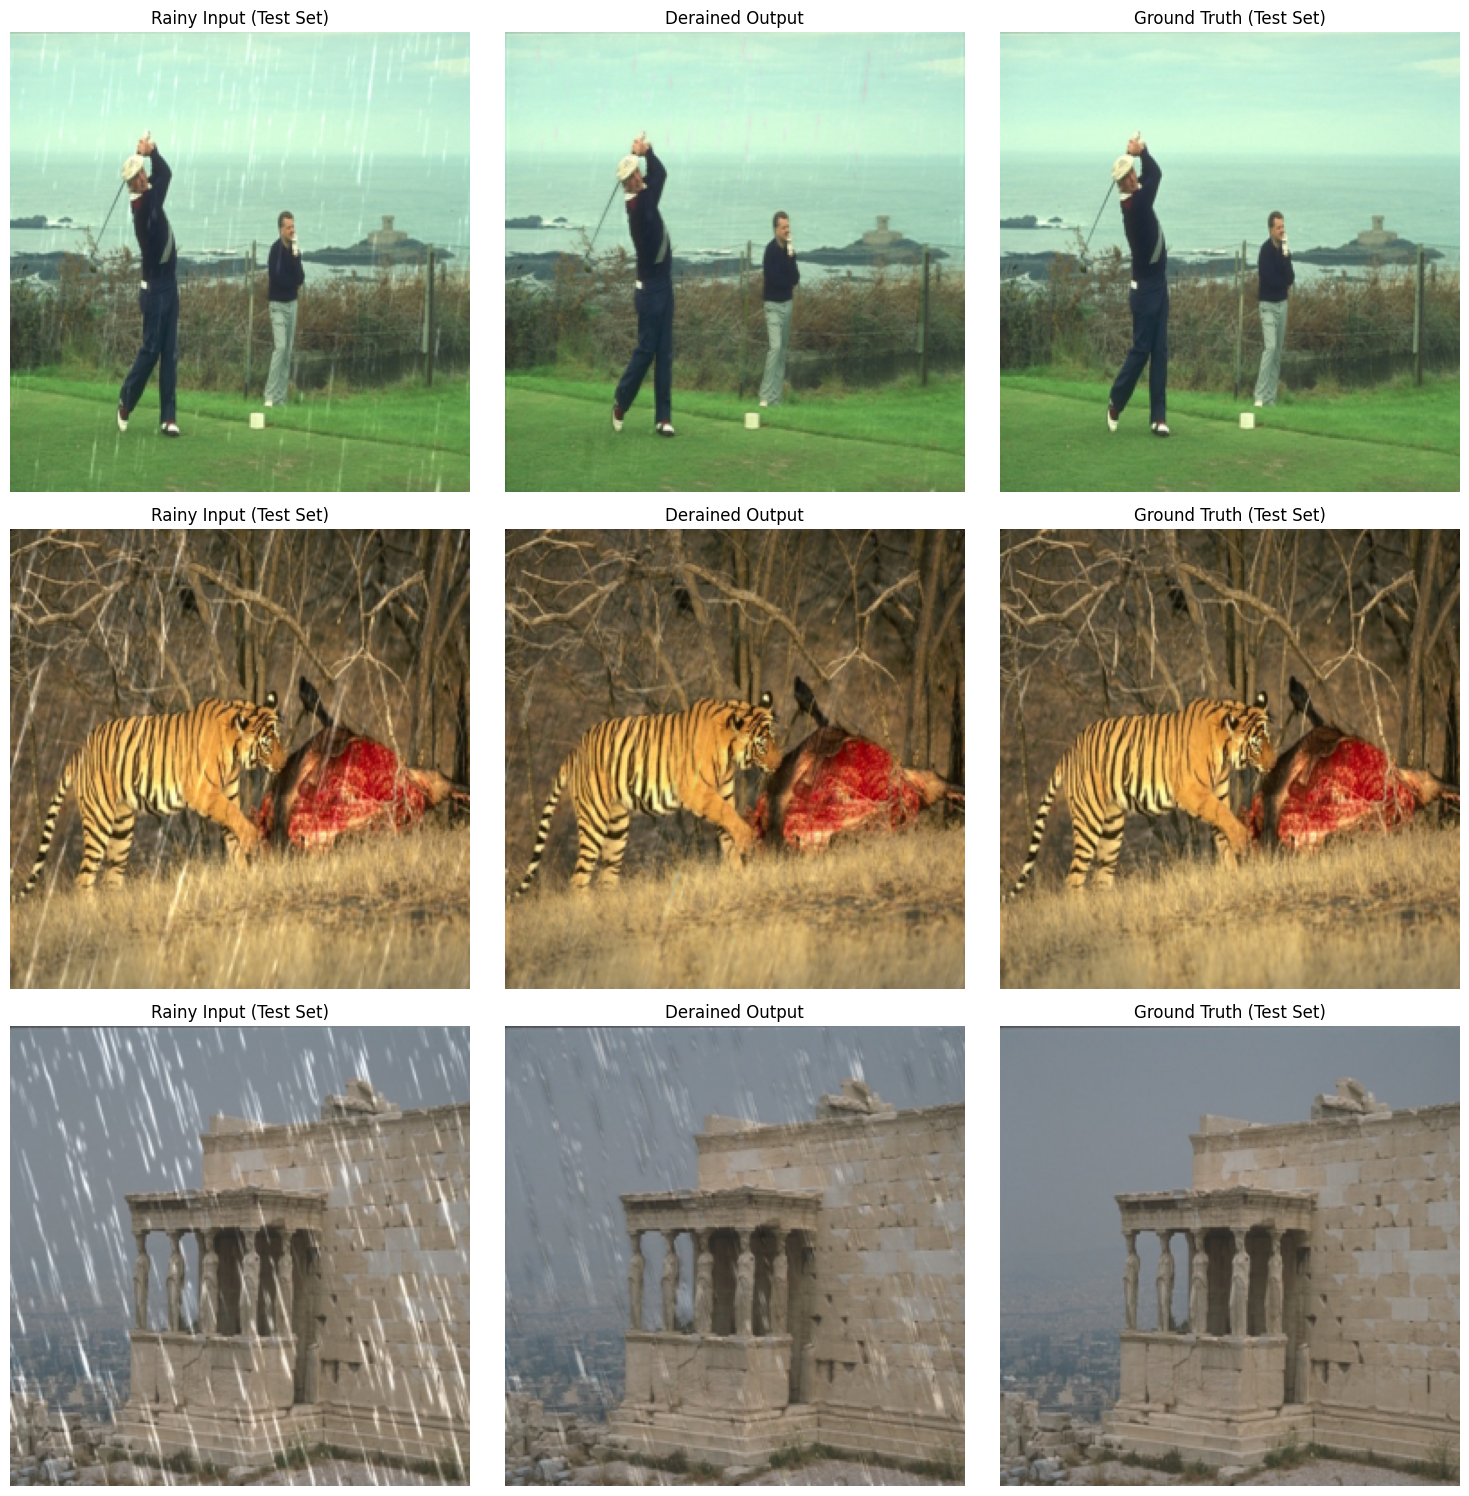

In [7]:
# --- 1. Plot Training and Validation Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training & Validation Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Calculate PSNR and SSIM on the Test Set ---
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

total_psnr = 0.0
total_ssim = 0.0
num_samples = 0

model.eval()
with torch.no_grad():
    for rainy_img, clean_img in tqdm(test_loader, desc="Calculating Final Metrics on Test Set"):
        rainy_img = rainy_img.to(device)
        clean_img = clean_img.to(device)

        derained_img = model(rainy_img)

        # Clamp images to [0, 1] range for metrics
        derained_img.clamp_(0, 1)
        clean_img.clamp_(0, 1)

        total_psnr += psnr_metric(derained_img, clean_img) * rainy_img.size(0)
        total_ssim += ssim_metric(derained_img, clean_img) * rainy_img.size(0)
        num_samples += rainy_img.size(0)

avg_psnr = total_psnr / num_samples
avg_ssim = total_ssim / num_samples

print(f"\n--- Final Evaluation on Unseen Test Set ---")
print(f"Average PSNR: {avg_psnr:.4f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")

# --- 3. Visualize Results from the Test Set ---
def show_results(n=5):
    """Shows n random results from the test set."""
    # Get a batch of test data
    rainy_imgs, clean_imgs = next(iter(test_loader))

    rainy_imgs = rainy_imgs.to(device)

    model.eval()
    with torch.no_grad():
        derained_imgs = model(rainy_imgs)

    # Clamp to [0, 1] for visualization
    rainy_imgs.clamp_(0, 1)
    derained_imgs.clamp_(0, 1)
    clean_imgs.clamp_(0, 1)

    plt.figure(figsize=(15, n * 5))
    for i in range(n):
        if i >= len(rainy_imgs): break

        # Display Rainy Input
        ax = plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(rainy_imgs[i].cpu().permute(1, 2, 0))
        ax.set_title("Rainy Input (Test Set)")
        ax.axis("off")

        # Display Derained Output
        ax = plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(derained_imgs[i].cpu().permute(1, 2, 0))
        ax.set_title("Derained Output")
        ax.axis("off")

        # Display Ground Truth
        ax = plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(clean_imgs[i].cpu().permute(1, 2, 0))
        ax.set_title("Ground Truth (Test Set)")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

print("\n--- Visualizing Sample Results from Test Set ---")
show_results(n=5)
